In [2]:
%matplotlib widget

from tqdm.autonotebook import tqdm
import pandas as pd
import numpy as np
import os
import shlex
import torch

if torch.cuda.is_available():
    os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

from torch.utils.data import DataLoader
from BasisConvolution.util.hyperparameters import defaultHyperParameters, parseHyperParameters, finalizeHyperParameters
from BasisConvolution.util.arguments import parser
from BasisConvolution.sph.sphOps import sphOperationStates
from BasisConvolution.util.dataloader import datasetLoader, processFolder#, DataLoader
from BasisConvolution.util.augment import loadAugmentedFrame
from BasisConvolution.util.hyperparameters import make_hash, toPandaDict
from BasisConvolution.util.network import buildModel, runInference

In [3]:
hyperParameterDict = defaultHyperParameters()
hyperParameterDict['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
# hyperParameterDict['device'] = 'cpu'
hyperParameterDict['augmentAngle'] = False
hyperParameterDict['augmentJitter'] = False
hyperParameterDict['maxRollOut'] = 0

In [4]:
datasetPath = '../../datasets/SFBC/TGV_SFBC_dataset/dataset/train'
basisFunction = 'ffourier'
basisTerms = 4
windowFunction = 'None'

args = parser.parse_args(shlex.split(f'--fluidFeatures constant:1 --boundaryFeatures constant:1 --groundTruth compute[gradSym]:constant:1/constant:rho0 --basisFunctions {basisFunction} --basisTerms {basisTerms} --windowFunction {windowFunction} --maxUnroll 0 --frameDistance 0 --epochs 1'))

hyperParameterDict = parseHyperParameters(args, None)
hyperParameterDict['device'] = 'cuda'
hyperParameterDict['iterations'] = 2**10

train_ds = datasetLoader(processFolder(hyperParameterDict, datasetPath))
print('Dataset has {} samples'.format(len(train_ds)))


print(train_ds.fileFormat)

# print(len(train_ds))
train_loader = DataLoader(train_ds, shuffle=True, batch_size = hyperParameterDict['batchSize']).batch_sampler
train_iter = iter(train_loader)

finalizeHyperParameters(hyperParameterDict, train_ds)

config, attributes, currentState, priorState, trajectoryStates = loadAugmentedFrame(123, train_ds, hyperParameterDict)


Dataset has 12500 samples
testcase_II


/home/yusuf/miniconda3/envs/torch_sfbc/lib/python3.11/site-packages/BasisConvolution/util/hyperparameters.py:517: UserWarning: Boundary data requested but not available. Disabling boundary data.
  warnings.warn('Boundary data requested but not available. Disabling boundary data.')


In [5]:
from BasisConvolution.util.augment import loadAugmentedBatch

In [6]:
database = pd.DataFrame()

models = []

t = None
basisFunctions = ['ffourier', 'linear', 'ffourier_even', 'ffourier_odd', 'chebyshev']
for basisFunction in basisFunctions:
    # for basisTerms in [2,4,8]:
    for basisTerms in [4]:
        for windowFunction in ['None']:
            # print('Training for ', basisFunction, basisTerms, windowFunction)
            # args = parser.parse_args(shlex.split(f'--fluidFeatures attribute:a --groundTruth compute[rho]:constant:1/constant:rho0 --basisFunctions {basisFunction} --basisTerms {basisTerms} --windowFunction {windowFunction} --maxUnroll 0 --frameDistance 0 --epochs 1'))
            args = parser.parse_args(shlex.split(f'--fluidFeatures constant:1 --boundaryFeatures constant:1 --groundTruth compute[rho]:constant:1/constant:rho0 --basisFunctions {basisFunction} --basisTerms {basisTerms} --windowFunction {windowFunction} --maxUnroll 0 --frameDistance 0 --epochs 1'))

            hyperParameterDict = parseHyperParameters(args, None)
            hyperParameterDict['device'] = 'cuda'
            hyperParameterDict['iterations'] = 2**10
            hyperParameterDict['batchSize'] = 8
            # t.


            train_ds = datasetLoader(processFolder(hyperParameterDict, datasetPath))
            # print(len(train_ds))
            train_loader = DataLoader(train_ds, shuffle=True, batch_size = hyperParameterDict['batchSize']).batch_sampler
            train_iter = iter(train_loader)

            finalizeHyperParameters(hyperParameterDict, train_ds)

            if t is None:
                t = tqdm(range(hyperParameterDict['totalIterations']))
            t.reset( hyperParameterDict['totalIterations'])
            # t.n =
            t.set_description(f'{basisFunction} - {basisTerms} - {windowFunction}')

# print(hyperParameterDict['progressLabel'])

            model, optimizer, scheduler = buildModel(hyperParameterDict, verbose = False)

            model = model.train()

            iterLosses = []
            iterPSNRs = []
            bdatas = []
            # bdata = next(train_iter)
            for i in (range(hyperParameterDict['totalIterations'])):
                try:
                    bdata = next(train_iter)
                except StopIteration:
                    train_iter = iter(train_loader)
                    bdata = next(train_iter)
                bdatas.append(bdata)
                # print(bdata)
                configs, attributes, currentStates, priorStates, trajectoryStates = loadAugmentedBatch(bdata, train_ds, hyperParameterDict)
                # config, attributes, currentState, priorState, trajectoryStates = loadAugmentedFrame(bdata[0], train_ds, hyperParameterDict)

                optimizer.zero_grad()
                predictions = runInference(currentStates, configs, model, verbose = False)
                # print(predictions)
                gts = [traj[0]['fluid']['target'] for traj in trajectoryStates]

                losses = [torch.nn.functional.mse_loss(prediction, gt) for prediction, gt in zip(predictions, gts)]
                
                psnrs= [20 * torch.log10(gt.abs().max()) - 10 * torch.log10(loss) for gt, loss in zip(gts, losses)]
                loss = torch.stack(losses).mean()
                loss.backward()
                psnr = torch.stack(psnrs).mean()
                iterLosses.append([l.item() for l in losses])
                iterPSNRs.append([p.item() for p in psnrs])
                optimizer.step()
                t.set_description(f'{bdata} - {hyperParameterDict["progressLabel"]} - Loss: {loss.item():.4e}, PSNR: {psnr.item():.2f}')
                t.update()
                t.refresh()
            dataFrame = pd.DataFrame([toPandaDict(hyperParameterDict)] * len(bdatas))

            dataFrame['batches'] = bdatas
            for b in range(len(bdata)):
                dataFrame['losses_{}'.format(b)] = [iterLosses[i][b] for i in range(len(bdatas))]
                dataFrame['psnrs_{}'.format(b)] = [iterPSNRs[i][b] for i in range(len(bdatas))]

            dataFrame['losses'] = [np.mean(iterLosses[i]) for i in range(len(bdatas))]
            dataFrame['psnrs'] = [np.mean(iterPSNRs[i]) for i in range(len(bdatas))]
            dataFrame['iteration'] = np.arange(len(bdatas))

            database = pd.concat([database, dataFrame], ignore_index = True)
            models.append(model)

            # break
        # break
    # break

/home/yusuf/miniconda3/envs/torch_sfbc/lib/python3.11/site-packages/BasisConvolution/util/hyperparameters.py:517: UserWarning: Boundary data requested but not available. Disabling boundary data.
  warnings.warn('Boundary data requested but not available. Disabling boundary data.')


  0%|          | 0/1024 [00:00<?, ?it/s]

/home/yusuf/miniconda3/envs/torch_sfbc/lib/python3.11/site-packages/BasisConvolution/util/hyperparameters.py:517: UserWarning: Boundary data requested but not available. Disabling boundary data.
  warnings.warn('Boundary data requested but not available. Disabling boundary data.')
/home/yusuf/miniconda3/envs/torch_sfbc/lib/python3.11/site-packages/BasisConvolution/util/hyperparameters.py:517: UserWarning: Boundary data requested but not available. Disabling boundary data.
  warnings.warn('Boundary data requested but not available. Disabling boundary data.')
/home/yusuf/miniconda3/envs/torch_sfbc/lib/python3.11/site-packages/BasisConvolution/util/hyperparameters.py:517: UserWarning: Boundary data requested but not available. Disabling boundary data.
  warnings.warn('Boundary data requested but not available. Disabling boundary data.')
/home/yusuf/miniconda3/envs/torch_sfbc/lib/python3.11/site-packages/BasisConvolution/util/hyperparameters.py:517: UserWarning: Boundary data requested but

In [7]:
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

In [8]:
basisTerms = database['basisTerms'].unique()
basisFunctions = database['basisFunctions'].unique()

print(basisTerms)
print(basisFunctions)

hues = sns.color_palette(n_colors = len(basisFunctions))
linestyles = ['--', '-', ':', '-.']

[4]
['ffourier' 'linear' 'ffourier_even' 'ffourier_odd' 'chebyshev']


In [9]:
import matplotlib.pyplot as plt

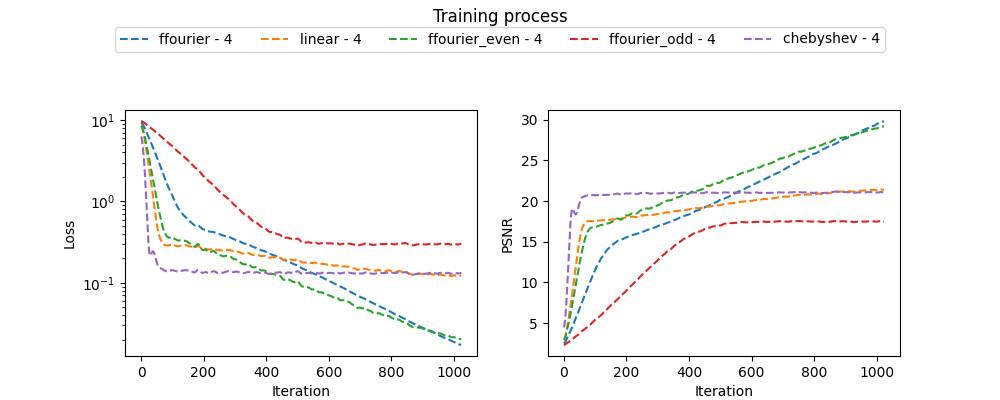

In [10]:
fig, axis = plt.subplots(1,2, figsize = (10,4), sharey = False, squeeze= False)

for i, basisFunction in enumerate(basisFunctions):
    for j, basisTerm in enumerate(basisTerms):
        subDatabase = database[(database['basisFunctions'] == basisFunction) & (database['basisTerms'] == basisTerm)]
        # subDatabase = subDatabase[subDatabase['dimension'] == 3]

        iters = subDatabase['iteration']
        losses = subDatabase['losses']
        psnrs = subDatabase['psnrs']

        losses = gaussian_filter1d(losses, sigma = 5)
        psnrs = gaussian_filter1d(psnrs, sigma = 5)

        axis[0,0].plot(iters, losses, label = f'{basisFunction} - {basisTerm}', color = hues[i], ls = linestyles[j])
        axis[0,1].plot(iters, psnrs, label = f'{basisFunction} - {basisTerm}', color = hues[i], ls = linestyles[j])

axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Iteration')
axis[0,0].set_ylabel('Loss')
# axis[0,0].legend(ncol = 2)

axis[0,1].set_xlabel('Iteration')
axis[0,1].set_ylabel('PSNR')

handles, labels = axis[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol = 5,bbox_to_anchor=(0.5, 0.95))

fig.suptitle('Training process')
fig.subplots_adjust(top = 0.725)
# fig.bbox_inches = 'tight'

# fig.tight_layout()